# Data preparation

In [2]:
from difflib import SequenceMatcher
import pandas as pd
import re

In [6]:
df_zero_llama3 = pd.read_csv('output_zeroshot_llama3.csv')
df_one_llama3 = pd.read_csv('output_oneshot_llama3.csv')
df_zero_gemma2 = pd.read_csv('output_zeroshot_gemma2.csv')
df_one_gemma2 = pd.read_csv('output_oneshot_gemma2.csv')

In [3]:
def clean_text(text):
    return re.sub(r'<<<|>>>', '', text).strip().lower()

def extract_aligned_prediction(mt_text, raw_output):
    if not isinstance(mt_text, str) or not isinstance(raw_output, str):
        return None

    cleaned_mt = clean_text(mt_text)
    lines = raw_output.strip().split('\n')

    best_match = None
    best_ratio = 0.0

    for line in lines:
        line_clean = clean_text(line)
        ratio = SequenceMatcher(None, cleaned_mt, line_clean).ratio()

        if ratio > best_ratio:
            best_ratio = ratio
            best_match = line.strip()

    if best_ratio >= 0.8:
        return best_match
    else:
        return None


In [7]:
df_one_gemma2['prediction_hall'] = df_one_gemma2.apply(
    lambda row: extract_aligned_prediction(row['mt_text'], row['raw_output']), axis=1
)


In [9]:
df_one_llama3['prediction_hall'] = df_one_llama3.apply(
    lambda row: extract_aligned_prediction(row['mt_text'], row['raw_output']), axis=1
)

In [11]:
df_zero_llama3['prediction_hall'] = df_zero_llama3.apply(
    lambda row: extract_aligned_prediction(row['mt_text'], row['raw_output']), axis=1
)

In [12]:
df_zero_gemma2['prediction_hall'] = df_zero_gemma2.apply(
    lambda row: extract_aligned_prediction(row['mt_text'], row['raw_output']), axis=1
)

In [20]:
import re

def extract_prediction_label(output_text):
    if not isinstance(output_text, str):
        return None

    output_text = output_text.lower()

    labels = [
        "no_hallucination",
        "small_hallucination",
        "partial_hallucination",
        "full_hallucination"
    ]

    for label in labels:
        # Patrón: número opcional + separador opcional + label
        pattern = rf"(\d+[\._]?\s*)?{label}"
        if re.search(pattern, output_text):
            return label

    return None


In [21]:
df_list = [df_one_gemma2, df_one_llama3, df_zero_gemma2, df_zero_llama3]

for df in df_list:
    df['prediction_label'] = df['raw_output'].apply(extract_prediction_label)

In [24]:
df_names = ['one_gemma2', 'one_llama3', 'zero_gemma2', 'zero_llama3']

for df, name in zip(df_list, df_names):
    df.to_csv(f'clean_output_{name}.csv', index=False)

# Overlap analysis

In [27]:
df_dict = {
    'df_one_gemma2': df_one_gemma2,
    'df_one_llama3': df_one_llama3,
    'df_zero_gemma2': df_zero_gemma2,
    'df_zero_llama3': df_zero_llama3,
}

# Lista para ir acumulando los DataFrames enriquecidos
df_combined = []

# Recorremos el diccionario y agregamos columnas a cada df
for name, df in df_dict.items():
    # Extraer método y modelo desde el nombre
    parts = name.split('_')  # ['df', 'one', 'gemma2']
    prompt_method = parts[1]
    model = parts[2]

    # Crear copia del DataFrame para no modificar el original
    df_temp = df.copy()
    df_temp['prompt_method'] = prompt_method
    df_temp['model'] = model

    # Agregar a la lista
    df_combined.append(df_temp)

# Unir todos los DataFrames en uno solo
df_all = pd.concat(df_combined, ignore_index=True)


In [30]:
def extract_spans(text):
    """Extrae lista de spans dentro de <<< >>>"""
    if not isinstance(text, str):
        return []
    return re.findall(r'<<<(.*?)>>>', text)

def normalize(text):
    """Limpia espacios y minúsculas para comparación justa"""
    return text.lower().strip()

def compare_spans(row):
    human_spans = [normalize(s) for s in extract_spans(row['ground_truth_text'])]
    model_spans = [normalize(s) for s in extract_spans(row['prediction_hall'])]

    if not human_spans and not model_spans:
        return 'true_negative'
    elif human_spans == model_spans:
        return 'exact_match'
    elif human_spans and model_spans:
        return 'partial_or_different'
    elif human_spans and not model_spans:
        return 'false_negative'
    elif not human_spans and model_spans:
        return 'false_positive'
    else:
        return 'unclassified'


In [31]:
df_all['span_match_type'] = df_all.apply(compare_spans, axis=1)

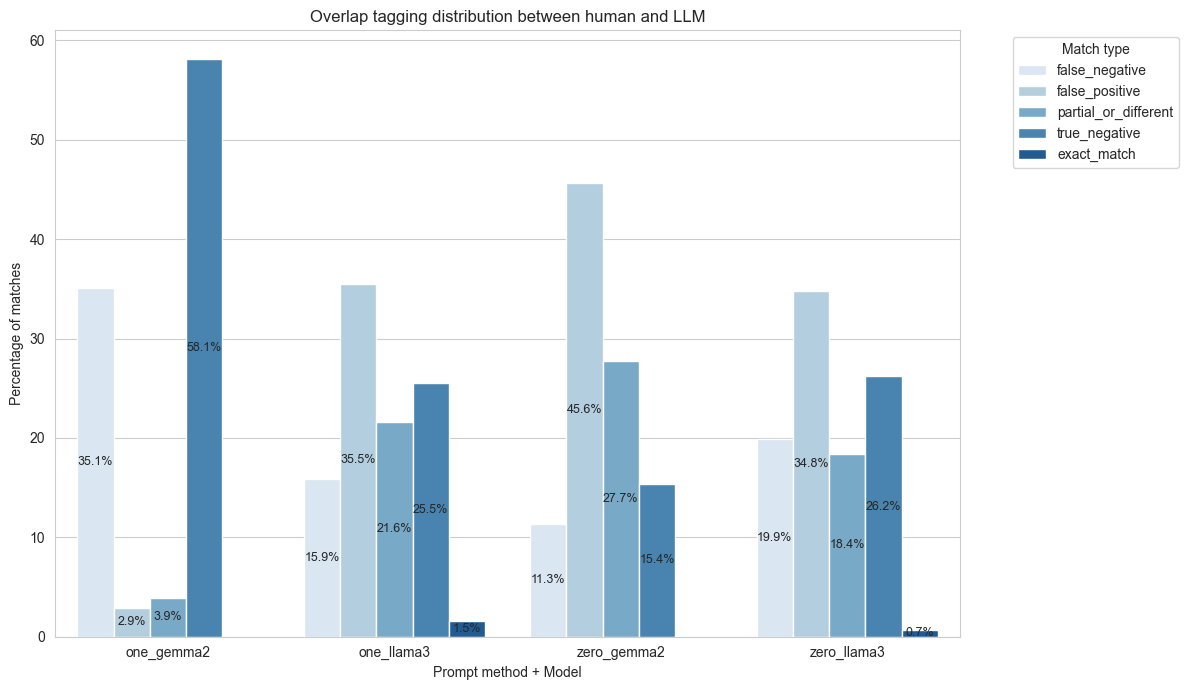

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Agrupamos y normalizamos (proporciones)
grouped = (
    df_all
    .groupby(['prompt_method', 'model', 'span_match_type'])
    .size()
    .reset_index(name='count')
)

# Total por combinación para calcular porcentaje
total = grouped.groupby(['prompt_method', 'model'])['count'].transform('sum')
grouped['percent'] = 100 * grouped['count'] / total

# Creamos columna combinada para el eje X
grouped['combo'] = grouped['prompt_method'] + '_' + grouped['model']

# Gráfico
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=grouped,
    x='combo',
    y='percent',
    hue='span_match_type',
    palette='Blues'
)

# Etiquetas de porcentaje sobre cada barra
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

plt.title('Overlap tagging distribution between human and LLM')
plt.xlabel('Prompt method + Model')
plt.ylabel('Percentage of matches')
plt.legend(title='Match type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Graficos resumen

In [42]:
#Uniendo datos faltantes
df_source = pd.read_csv('data_filtered.csv')

# Primero, nos aseguramos de tener solo las columnas necesarias en df_source
df_source_subset = df_source[['mt_text', 'score_comet_qe', 'class_hall']]

# Luego, hacemos el merge sobre mt_text
df_merged = df_all.merge(df_source_subset, on='mt_text', how='left')


In [43]:
df_merged = df_merged.drop('class_hall', axis=1)

In [39]:
df_merged.to_csv('all_results.csv')

C:\Users\belen\AppData\Local\Temp\ipykernel_27256\1632017953.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_df["group"] = accuracy_df["prompt_method"] + "_" + accuracy_df["model"]


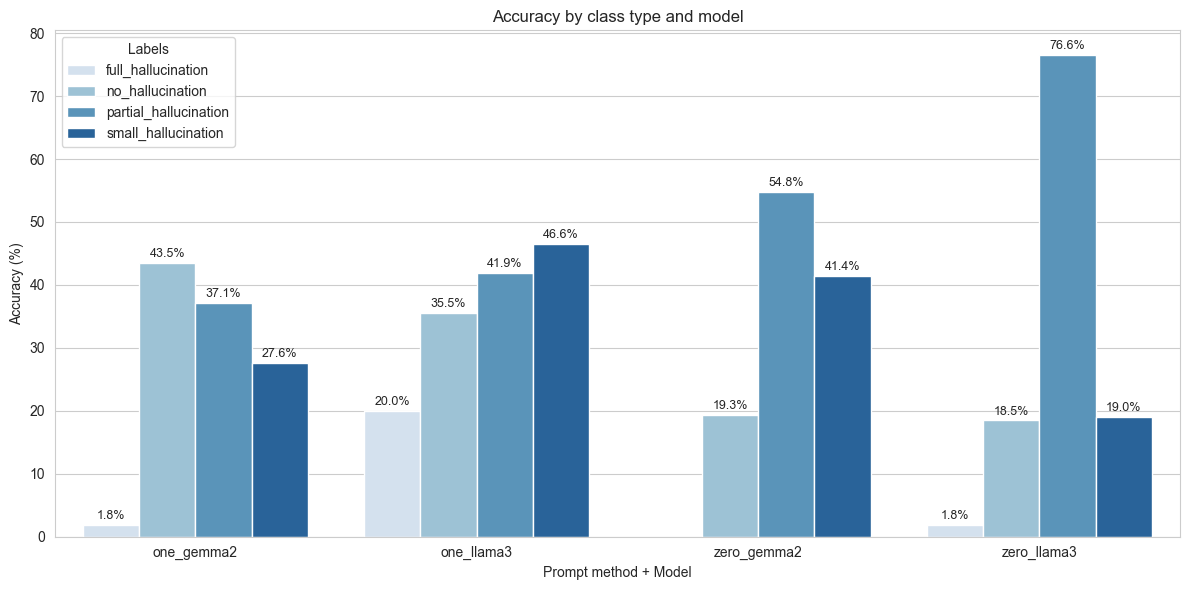

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Normalización de etiquetas
def normalize_label(label):
    if not isinstance(label, str):
        return None
    return label.lower().split("_", 1)[-1] if "_" in label else label.lower()

# Normalizar etiquetas
df_merged["ground_truth_classification_norm"] = df_merged["ground_truth_classification"].apply(normalize_label)

# Crear columna de acierto
df_merged["label_match"] = df_merged["ground_truth_classification_norm"] == df_merged["prediction_label"]

# Agrupamiento para gráfico
grouped = (
    df_merged.groupby(["prompt_method", "model", "ground_truth_classification_norm", "label_match"])
    .size()
    .reset_index(name="count")
)

# Total por grupo para normalización
totals = grouped.groupby(["prompt_method", "model", "ground_truth_classification_norm"])["count"].transform("sum")
grouped["percent"] = grouped["count"] / totals * 100

# Filtrar solo aciertos
accuracy_df = grouped[grouped["label_match"] == True]

# Preparar etiquetas X
accuracy_df["group"] = accuracy_df["prompt_method"] + "_" + accuracy_df["model"]

# Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=accuracy_df,
    x="group",
    y="percent",
    hue="ground_truth_classification_norm",
    palette="Blues"
)

# Agregar etiquetas de porcentaje sobre cada barra
for container in barplot.containers:
    barplot.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9, padding=2)

plt.title("Accuracy by class type and model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Prompt method + Model")
plt.legend(title="Labels")
plt.tight_layout()
plt.show()


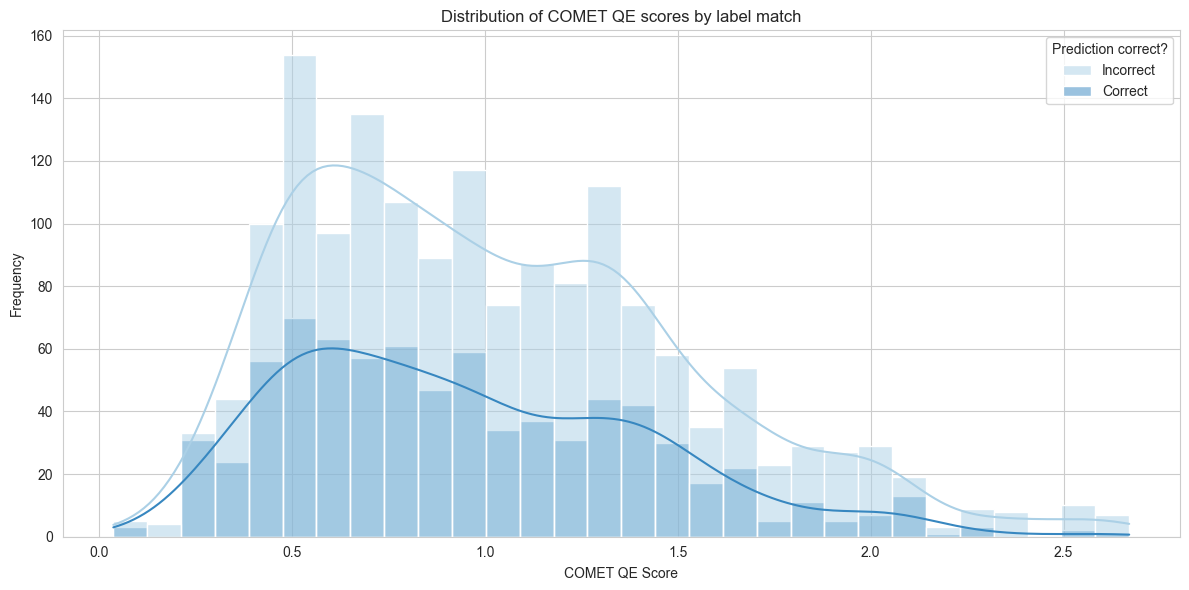

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear columna binaria de acierto
df_merged["label_match"] = (
    df_merged["ground_truth_classification_norm"] 
    == df_merged["prediction_label"]
)

# Columna descriptiva para la leyenda
df_merged["label_match_desc"] = df_merged["label_match"].map({
    True: "Correct",
    False: "Incorrect"
})

# -------------------------
# HISTOGRAMA DE COMET QE
# -------------------------
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df_merged,
    x="score_comet_qe",
    hue="label_match_desc",  # Esto genera la leyenda automáticamente
    bins=30,
    kde=True,
    palette="Blues",
    multiple="layer",
    legend=True  # Esto asegura que la leyenda se muestre
)

# Personalizar el título de la leyenda (opcional)
ax.get_legend().set_title("Prediction correct?")  # Cambia el título de la leyenda

# Configurar etiquetas y título
ax.set_title("Distribution of COMET QE scores by label match")
ax.set_xlabel("COMET QE Score")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

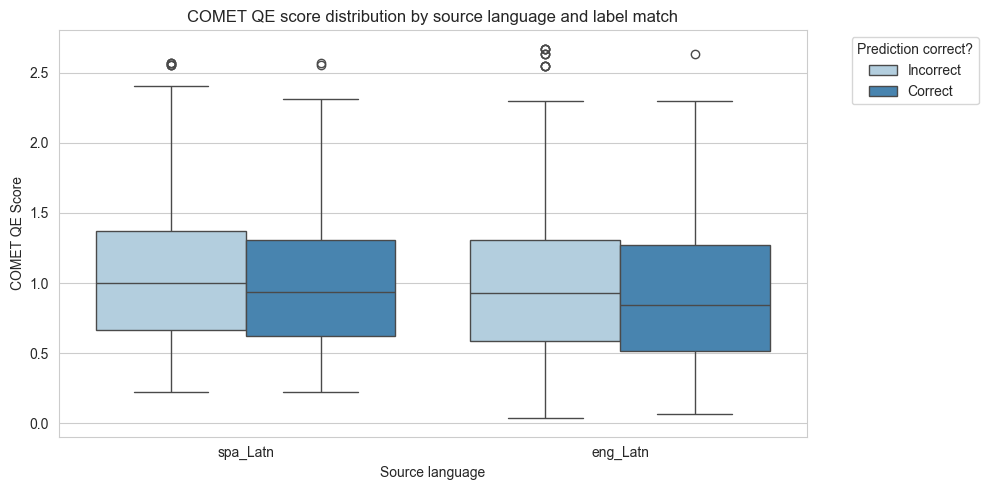

In [56]:

# -------------------------
# BOX PLOT POR IDIOMA
# -------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_merged,
    x="src_lang",
    y="score_comet_qe",
    hue="label_match_desc",
    palette="Blues"
)
plt.title("COMET QE score distribution by source language and label match")
plt.xlabel("Source language")
plt.ylabel("COMET QE Score")
plt.legend(title="Prediction correct?", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()